# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)


#enter your foldername assignments/assignement1

FOLDERNAME = "AA personal/Learning/CS Degree/assignment1/assignment1"
              
assert FOLDERNAME is not None , "[!] Enter the foldername"

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

#this will download the CIFAR-10 dataset to your drive 
#if it isnt already there

%cd drive/My\ Drive/$FOLDERNAME/CV7062610/datasets/
!bash get_datasets.sh
%cd /content


Mounted at /content/drive
/content/drive/My Drive/AA personal/Learning/CS Degree/assignment1/assignment1/CV7062610/datasets
--2023-04-04 19:09:31--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  26.8MB/s    in 6.2s    

2023-04-04 19:09:37 (26.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


In [3]:
import random
import numpy as np
from CV7062610.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# New Section

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/content/drive/MyDrive/' + FOLDERNAME + '/CV7062610/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `CV7062610/classifiers/softmax.py`.


In [9]:
# First implement the naive softmax loss function with nested loops.
# Open the file CV7062610/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from CV7062610.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.315756
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

At initialization all scores representing probability's will be roughly equal due to random initialization.

let C be the number of classes in our case C = 10. we would assume the probability of the correct class to be eqaul across the classes due to the random initialization.

as expected we recive,

the pobability of correct class is roughly:

-log(1/C) = log(C) = log(10) = -log(0.1)



In [10]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from CV7062610.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.118033 analytic: -1.118033, relative error: 4.430658e-08
numerical: 1.019609 analytic: 1.019609, relative error: 3.137665e-08
numerical: 0.676724 analytic: 0.676724, relative error: 3.650001e-08
numerical: -0.844137 analytic: -0.844137, relative error: 1.072908e-10
numerical: 4.097542 analytic: 4.097542, relative error: 5.528575e-09
numerical: -0.519383 analytic: -0.519383, relative error: 3.685528e-08
numerical: 1.522761 analytic: 1.522761, relative error: 3.127192e-08
numerical: -0.274581 analytic: -0.274581, relative error: 4.246424e-08
numerical: -1.578470 analytic: -1.578470, relative error: 9.964107e-09
numerical: 1.216296 analytic: 1.216296, relative error: 5.303467e-09
numerical: 1.862656 analytic: 1.862655, relative error: 3.783883e-08
numerical: 1.475391 analytic: 1.475391, relative error: 2.138663e-09
numerical: 2.803348 analytic: 2.803348, relative error: 1.224566e-08
numerical: -0.739959 analytic: -0.739959, relative error: 7.946575e-08
numerical: -4.091464 a

In [11]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from CV7062610.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.315756e+00 computed in 0.094647s
vectorized loss: 2.315756e+00 computed in 0.012513s
Loss difference: 0.000000
Gradient difference: 0.000000


In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from CV7062610.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# save the best trained softmax classifer in best_softmax.                     #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [9e-8, 1e-7, 5e-7]
regularization_strengths = [1.8e4, 2e4, 5e4, 2e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#nested for loop over alpha learning rate and reg strength
for alpha in learning_rates:
    for reg in regularization_strengths:
        #create instance of softMax
        softmax = Softmax()
        #train modle using alpha and reg
        softmax.train(X_train, y_train, learning_rate=alpha, reg=reg, num_iters=1500, verbose=True)
        #get predicted values of train and validation
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        #compute val and train accuracy
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_val = np.mean(y_val == y_val_pred)
        #store results
        results[(alpha, reg)] = (accuracy_train, accuracy_val)
        #change if beats best
        if accuracy_val > best_val:
            best_val = accuracy_val
            best_softmax = softmax



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 282.414965
iteration 100 / 1500: loss 203.604794
iteration 200 / 1500: loss 147.137844
iteration 300 / 1500: loss 106.728675
iteration 400 / 1500: loss 77.563370
iteration 500 / 1500: loss 56.599140
iteration 600 / 1500: loss 41.277327
iteration 700 / 1500: loss 30.327311
iteration 800 / 1500: loss 22.490820
iteration 900 / 1500: loss 16.800409
iteration 1000 / 1500: loss 12.665871
iteration 1100 / 1500: loss 9.700309
iteration 1200 / 1500: loss 7.545776
iteration 1300 / 1500: loss 5.950564
iteration 1400 / 1500: loss 4.868958
iteration 0 / 1500: loss 311.690731
iteration 100 / 1500: loss 216.343947
iteration 200 / 1500: loss 150.993479
iteration 300 / 1500: loss 105.718470
iteration 400 / 1500: loss 74.101559
iteration 500 / 1500: loss 52.165902
iteration 600 / 1500: loss 36.984097
iteration 700 / 1500: loss 26.333002
iteration 800 / 1500: loss 18.934670
iteration 900 / 1500: loss 13.846919
iteration 1000 / 1500: loss 10.213029
iteration 1100 / 1500: loss 7.69

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


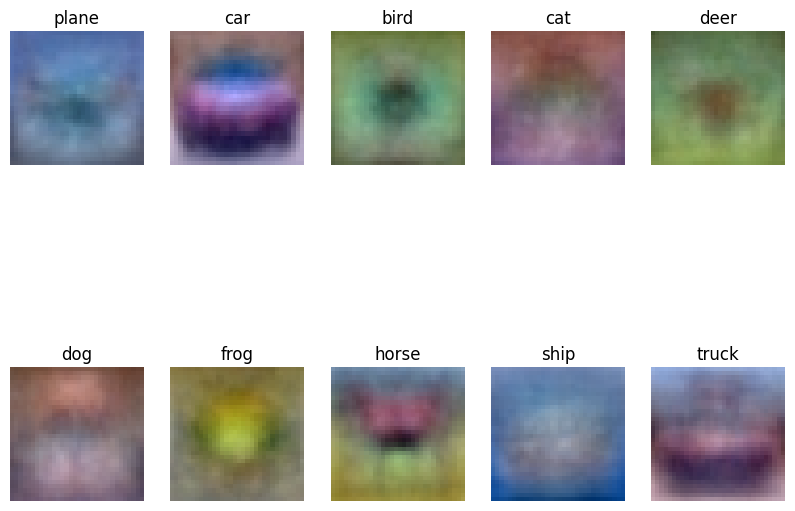

In [14]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])